<a href="https://colab.research.google.com/github/Eddie-Teo/Project_IT113/blob/main/L10/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition using 2D-Pose

In this practical, we will apply RNN to develop a model to recognise activities such as jumping, boxing, waving 1 hand, etc. The activity is defined as a sequence of human poses (given by keypoints of skeletal joints) and these poses are estimated by a pretrained model (Google's PoseNet). Some use cases for activity recognition is to detect fall, gait analysis.


## Section 1 - Import Libraries and Setup Folders

Let's import all the necessary libraries

In [3]:
import pandas as pd
import os
import time
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

## Section 2 - Dataset

We will be using the following dataset from
https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input

The data is 2D positions (x,y coordinates) of 18 joints across a timeseries of 32 frames (window-width), with an associated class label for the frame series.

The dataset consist of the following files:
- X_test.txt : testing dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- X_train.txt : training dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- X_val.txt : validation dataset x inputs (36 keypoints per line, 32 lines per datapoint)
- Y_test.txt : testing class labels
- Y_train.txt : training class labels
- Y_val.txt : validation class labels

In [1]:
!wget https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/2D-Pose-Data.zip
!unzip 2D-Pose-Data.zip

--2025-12-15 10:54:28--  https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/2D-Pose-Data.zip
Resolving nyp-aicourse.s3.ap-southeast-1.amazonaws.com (nyp-aicourse.s3.ap-southeast-1.amazonaws.com)... 3.5.149.131, 3.5.146.197, 52.219.132.159, ...
Connecting to nyp-aicourse.s3.ap-southeast-1.amazonaws.com (nyp-aicourse.s3.ap-southeast-1.amazonaws.com)|3.5.149.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20129409 (19M) [application/zip]
Saving to: ‘2D-Pose-Data.zip’

2D-Pose-Data.zip    100%[===================>]  19.20M  7.72MB/s    in 2.5s    

2025-12-15 10:54:31 (7.72 MB/s) - ‘2D-Pose-Data.zip’ saved [20129409/20129409]

Archive:  2D-Pose-Data.zip
   creating: 2D-Pose-Data/
  inflating: 2D-Pose-Data/README.md  
  inflating: 2D-Pose-Data/X_test.txt  
  inflating: 2D-Pose-Data/X_train.txt  
  inflating: 2D-Pose-Data/X_val.txt  
  inflating: 2D-Pose-Data/Y_test.txt  
  inflating: 2D-Pose-Data/Y_train.txt  


In [4]:
train_df = pd.read_csv('2D-Pose-Data/X_train.txt', header=None)
train_label_df = pd.read_csv('2D-Pose-Data/Y_train.txt', header=None)
test_df = pd.read_csv('2D-Pose-Data/X_test.txt', header=None)
test_label_df = pd.read_csv('2D-Pose-Data/Y_test.txt', header=None)

In [5]:
#examine first few rows
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,295.914,161.579,307.693,203.413,281.546,203.368,274.997,251.562,267.194,293.253,...,328.528,411.922,294.546,156.420,305.002,156.418,0.0,0.0,318.083,161.632
1,295.855,161.600,307.684,203.408,281.529,203.385,274.989,251.574,267.191,291.961,...,328.493,410.630,293.252,157.686,303.706,157.706,0.0,0.0,318.024,161.654
2,293.296,161.620,307.655,203.410,280.228,203.382,274.986,251.591,267.262,289.373,...,328.522,411.946,289.374,157.686,299.798,157.714,0.0,0.0,316.776,161.679
3,291.978,161.658,307.619,204.678,278.918,204.659,275.001,254.114,269.794,289.363,...,328.479,411.947,288.101,157.727,298.487,158.985,0.0,0.0,316.720,161.697
4,288.063,168.120,306.362,209.835,276.384,211.108,275.010,255.461,275.003,294.581,...,329.774,411.884,286.774,161.596,297.133,161.601,0.0,0.0,315.402,166.840


In [6]:
#check the distribution of the labels
train_label_df.value_counts()

,count
0,
5,5055
4,4760
3,4724
2,3545
1,2400
6,2141


## Section 3- Create the input data

We cannot use the panda dataframe (which is 2D) directly with our LSTM network. We need to create a dataset that consists sequence of 32 timesteps (frames) of 36 keypoints. In other words, we need our data to be of the shape (batch_size, 32, 36).

In addition, we saw earlier that our labels starts from 1 to 6 (total of 6 classes). However, the deep learning model will predict labels starting from 0 to 5.  So we need to map the labels to 0-5 by subtracting the original values by 1.

Our labels are the following:

```
labels = ["JUMPING", "JUMPING_JACKS", "BOXING", "WAVING_2HANDS", "WAVING_1HAND", "CLAPPING_HANDS"]
```

In [7]:
# convert the dataframe to numpy array and bunch every 32 rows together as a sequence of 32 timesteps
X_train = train_df.to_numpy().reshape(-1, 32, 36)

# convert labels from 1-6 to 0-5.
y_train = train_label_df.to_numpy() - 1

print(X_train.shape)
print(y_train.shape)

(22625, 32, 36)
(22625, 1)


In [8]:
X_test = test_df.to_numpy().reshape(-1, 32, 36)
y_test = test_label_df.to_numpy() - 1

print(X_test.shape)
print(y_test.shape)

(5751, 32, 36)
(5751, 1)


## Section 4 - Visualize Our Dataset



We can view each frame as a timestep on the x-axis, and each of the 36 numbers (the x and y coordinates of 18 joints) as individual line plots.  It provides some visual clue as to how the different joints move over time, but they are still difficult to imagine and visualize.

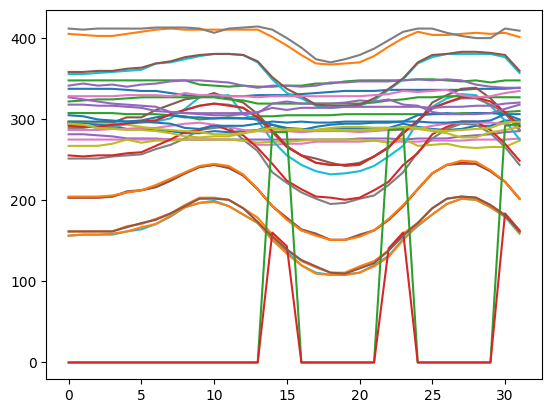

In [9]:
%matplotlib inline
sample = 0
plt.plot(X_train[sample])
plt.show()

A better way to visualize is do a scatter plot of the X and Y coordianates of the various joints and animating them so that we can see their movements over time.

NOTE: These are the various types of actions captured in the dataset:
JUMPING, JUMPING_JACKS, BOXING, WAVING_2HANDS, WAVING_1HAND", "CLAPPING_HANDS"

In [10]:
sample = 0

# This function returns a set of data for every frame that is
# called from the animation.FuncAnimation below.
#
def animate_pose(frame):
    # Retrieve the even number values as X-coordinates
    # and the odd number values as Y-coordinates
    #
    # Once you have these 2 sets of values, you can
    # pass them into the line.set_data to get matplotlib
    # to draw a scatter plot
    #
    graph_x = X_train[sample][frame][0::2]
    graph_y = X_train[sample][frame][1::2]
    line.set_data(graph_x, graph_y)
    return line,

fig, ax = plt.subplots()
plt.close()

ax.set_xlim(0, 800)
ax.set_ylim(600, 0)

line, = ax.plot([], [], 'o', color='black');

anim = animation.FuncAnimation(fig, animate_pose, 32,  interval=50, blit=True)
rc('animation', html='jshtml')
anim

## Section 5 - Define and Train Your Model

We will next create a model using LSTM layer to process sequence (time-series) data. We will start with very simple model, consisting of only a single LSTM layer followed by Dense layer for classification. We will also add in Dropout layer.

Since our target label is not one-hot-encoded, we will specify `sparse_categorical_crossentropy` as our loss function.

You may find that a good validation accuracy for you model may hover near about 85-90%.

In [11]:
class ActivityLSTM(nn.Module):
    def __init__(self, input_size=36, hidden_size=128, num_classes=6, dropout=0.2):
        super(ActivityLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True
        )

        # Dropout and fully-connected layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        # Output: (batch_size, seq_len, hidden_size)
        out, (h_n, c_n) = self.lstm(x)
        # Take the last hidden state of last layer for classification
        out = h_n[-1]  # shape: (batch_size, hidden_size)
        out = self.dropout(out)
        out = self.fc(out)
        return out  # logits (no softmax here)

In [12]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.squeeze(), dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.squeeze(), dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [13]:
for X, y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([256, 32, 36])
torch.Size([256])


In [14]:
# Set device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [15]:
model = ActivityLSTM(input_size=36, hidden_size=128, num_classes=6, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
import wandb

wandb.login(key="6fc2dc8315b5cb18af2095660ae5fffdca60529f")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eddteots (eddteots-abc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [17]:
def train_eval(model, criterion, optimizer, train_loader, test_loader):

    # ======================
    # Initialize W&B run
    # ======================
    wandb.init(
        project="human-activity-recognition",
        config={
            "epochs": 40,
            "batch_size": train_loader.batch_size,
            "learning_rate": optimizer.param_groups[0]["lr"],
            "model": "ActivityLSTM",
            "hidden_size": model.hidden_size,
            "num_layers": model.lstm.num_layers,
            "dropout": model.dropout.p
        }
    )

    # root_logdir = os.path.join('.', "tb_logs")
    # run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    # logdir = os.path.join(root_logdir, run_id)
    # os.makedirs(logdir, exist_ok=True)
    # writer = SummaryWriter(log_dir=logdir)

    num_epochs = wandb.config.epochs
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
            total_correct += (outputs.argmax(1) == batch_y).sum().item()

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_acc  = total_correct / len(train_loader.dataset)

        # ====== Validation ======
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)
                val_correct += (outputs.argmax(1) == batch_y).sum().item()

        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc  = val_correct / len(test_loader.dataset)

        # ====== Logging ======
        wandb.log({
            "epoch": epoch + 1,
            "train/loss": avg_train_loss,
            "train/accuracy": avg_train_acc,
            "val/loss": avg_val_loss,
            "val/accuracy": avg_val_acc
        })


        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

        # ====== Early stopping ======
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model, "best_model_epoch.pt")

            # save the model to wandb as versioned artifact
            artifact = wandb.Artifact(
                name="activity-lstm-model",
                type="model",
                description="Best validation checkpoint"
            )
            artifact.add_file("best_model_epoch.pt")
            wandb.log_artifact(artifact)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    wandb.finish()

In [18]:
train_eval(model, criterion, optimizer, train_loader, test_loader)

Epoch [1/40] Train Loss: 1.1311, Acc: 0.5369 | Val Loss: 0.7602, Acc: 0.7122
Epoch [2/40] Train Loss: 0.6006, Acc: 0.7560 | Val Loss: 0.6316, Acc: 0.7569
Epoch [3/40] Train Loss: 0.4199, Acc: 0.8442 | Val Loss: 0.4248, Acc: 0.8301
Epoch [4/40] Train Loss: 0.3516, Acc: 0.8716 | Val Loss: 0.3561, Acc: 0.8785
Epoch [5/40] Train Loss: 0.3778, Acc: 0.8579 | Val Loss: 0.5480, Acc: 0.7886
Epoch [6/40] Train Loss: 0.3473, Acc: 0.8666 | Val Loss: 0.3326, Acc: 0.8559
Epoch [7/40] Train Loss: 0.2570, Acc: 0.9010 | Val Loss: 0.3399, Acc: 0.8805
Epoch [8/40] Train Loss: 0.2485, Acc: 0.9076 | Val Loss: 0.2975, Acc: 0.8877
Epoch [9/40] Train Loss: 0.2746, Acc: 0.8985 | Val Loss: 0.2121, Acc: 0.9158
Epoch [10/40] Train Loss: 0.2377, Acc: 0.9142 | Val Loss: 0.3768, Acc: 0.8461
Epoch [11/40] Train Loss: 0.1946, Acc: 0.9284 | Val Loss: 0.3157, Acc: 0.8819
Epoch [12/40] Train Loss: 0.2284, Acc: 0.9175 | Val Loss: 0.2580, Acc: 0.9099
Epoch [13/40] Train Loss: 0.1683, Acc: 0.9398 | Val Loss: 0.2009, Acc: 0.

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train/accuracy,▁▄▆▆▆▆▇▇▇▇▇▇▇██▇██▇▇▇█████████████
train/loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▂▄▆▃▅▆▆▇▅▆▆▇▇▇▆█▇█▆▇▇▇█▇▇████████
val/loss,█▇▄▄▆▃▄▃▂▄▃▃▂▂▂▂▂▂▁▃▂▂▂▁▂▂▁▁▁▂▁▁▁▂
epoch,34
train/accuracy,0.9752
train/loss,0.07416
val/accuracy,0.95183
val/loss,0.1534


## Section 6 - Scale / Translation Normalization

So far, we have not talked about how we can normalize our skeletal keypoints so that the pose data is scale / translation invariant. This means that regardless of how far the person is from the camera, or when the person moves left or right or up or down, the coordinates of all joint positions should always be relative to a fixed frame of reference.

To take care of translation (left / right / up / down) invariance, we are shift all points together so that neck point is always placed at (0, 0).

To take care of scale invariance, we estimate the torso height (which is either the length of the neck point to either hip, or the width of the shoulders). We then divide all joint coordinates by the torso height.

To do so, we will create a `process_joints()` function to include code to normalize the skeleton key points as described above:

1. ref = P[1] or the midpoint of P[2], P[5]
2. reflength = length(ref to P[8]) or length(ref to P[11])
3. Compute
   - P[i].x = (P[i].x - ref.x) / reflength
   - P[i].y = (P[i].y - ref.y) / reflength


In [ ]:
# Declare a function that can compute length (euclidean distance) between two points
#   (x1,y1) - (x2,y2)
def compute_length(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

# Process OpenPose's Joints

# NOTE: The "keypoints" parameter consists of an array of consecutive x and y values
# within the same array.
# keypoints = [p0.x, p0.y, p1.x, p1.y, p2.x, p2.y, ..., p17.x, p17.y] (a total of 36 values)
def process_joints(keypoints):

    normalized_keypoints = [0] * 36

    refx = 0
    refy = 0
    reflength = 1

    # Step 1: Let's find the reference point (neck)
    #
    if keypoints[2] != 0 or keypoints[3] != 0: # neck
        refx = keypoints[2]                # use the neck X, Y
        refy = keypoints[3]
    elif (keypoints[4] != 0 or keypoints[5] != 0) and (keypoints[10] != 0 or keypoints[11] != 0):
        refx = (keypoints[4] + keypoints[10]) / 2  # estimate the neck X, Y from the mid point
        refy = (keypoints[5] + keypoints[11]) / 2  # of the left/right shoulder

    # Step 2: Let's estimate the torso length.
    #
    if keypoints[16] != 0 and keypoints[17] != 0:
        reflength = compute_length(keypoints[16], keypoints[17], refx, refy)   # neck to right hip
    elif keypoints[22] != 0 and keypoints[23] != 0:
        reflength = compute_length(keypoints[22], keypoints[23], refx, refy)   # neck to left hip

    # Step 3:
    # Perform the translation and the scaling.
    #
    for i in range(0, 18):
        normalized_keypoints[i*2] = (keypoints[i*2] - refx) / reflength
        normalized_keypoints[i*2 + 1] = (keypoints[i*2 + 1] - refy) / reflength

    # Return the re-mapped and normalized result
    #
    return normalized_keypoints


We will apply the normalization to each row of keypoints (36 keypoints). We use `itertuples()` to iterate through each row of dataframe.

In [ ]:
def normalize(df):
    X = []
    for row in tqdm(df.itertuples(index=False)):
        X.append(process_joints(row))

    X = np.array(X)
    return X

In [ ]:
X_train_normalized = normalize(train_df).reshape(-1, 32, 36)
X_test_normalized = normalize(test_df).reshape(-1, 32, 36)

In [ ]:
X_train_t = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_t = torch.tensor(y_train.squeeze(), dtype=torch.long)
X_test_t  = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.squeeze(), dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [ ]:
model = ActivityLSTM(input_size=36, hidden_size=128, num_classes=6, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_eval(model, criterion, optimizer, train_loader, test_loader)


## Section 7 - Evaluate Model Performance

In [ ]:
def display_classification_confusion_matrix(model, train_loader, test_loader, labels, device='cpu'):
    """
    Compute and display confusion matrices and classification reports
    for both training and test sets in PyTorch.
    """
    model.eval()  # set model to evaluation mode
    model.to(device)

    # Helper to get predictions
    def get_all_preds(loader):
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = outputs.argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())
        return np.array(all_targets), np.array(all_preds)

    # Get predictions for train and test sets
    y_train_true, y_train_pred = get_all_preds(train_loader)
    y_test_true,  y_test_pred  = get_all_preds(test_loader)

    # Confusion matrices
    labels = np.array(labels)
    cm_train = confusion_matrix(y_train_true, y_train_pred)
    cm_test  = confusion_matrix(y_test_true,  y_test_pred)

    # Plot confusion matrices
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_train, labels, labels), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (Train Data)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_test, labels, labels), annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix (Test Data)")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

    plt.show()

    # Classification reports
    print("Train Data:")
    print("--------------------------------------------------------")
    print(classification_report(y_train_true, y_train_pred, target_names=labels))
    print("")
    print("Test Data:")
    print("--------------------------------------------------------")
    print(classification_report(y_test_true, y_test_pred, target_names=labels))

In [ ]:
labels = ["JUMPING", "JUMPING_JACKS", "BOXING", "WAVING_2HANDS", "WAVING_1HAND", "CLAPPING_HANDS"]

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
labels = ["JUMPING", "JUMPING_JACKS", "BOXING", "WAVING_2HANDS", "WAVING_1HAND", "CLAPPING_HANDS"]

display_classification_confusion_matrix(model, train_loader, test_loader, labels, device='cuda' if torch.cuda.is_available() else 'cpu')

# display_classification_confusion_matrix(model, X_train_normalized, y_train, X_test_normalized, y_test, labels)

## Section 8 - Save and Download Best Model



We will save the best model as TorchScript model so that we can deploy it later without the source code. Download the TorchScript model file. We will be using this for the next practical exercise.

In [ ]:
model = torch.load('best_model_epoch.pt', weights_only=False).to(device)
model.eval()


scripted_model = torch.jit.script(model)
scripted_model.save("activity_model_ts.pt")


In [ ]:
# Evaluate on test data
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {avg_test_loss:.4f}")

In [ ]:
sample_index = 2000

X, y = test_ds[sample_index]

In [ ]:
with torch.no_grad():
    pred = model(X.to(device)).cpu()
    predicted_label = np.argmax(pred)

In [ ]:
actual_label = y.item()

In [ ]:
print('actual = {}'.format(labels[actual_label]))
print('predicted = {}'.format(labels[predicted_label]))